# exp22_v3: 追加モデル（XGBoost, LightGBM, RandomForest）のOptuna最適化

**ベースライン**: exp22（冗長な特徴量の削減 + Optuna再最適化）

**変更点**:
- WeightedEnsemble, ExtraTreesを除外
- XGBoost, LightGBM, RandomForestを追加
- 各モデルをOptunaでパラメータチューニング

**使用モデル**:
1. Ridge
2. HistGradientBoosting
3. CatBoost
4. XGBoost（新規）
5. LightGBM（新規）
6. RandomForest（新規）

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')
import os

# 出力ディレクトリ
output_dir = '../output/exp22_v3'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
# ==================================================================================
# データの読み込みと特徴量作成（exp22と同じ）
# ==================================================================================

def load_and_preprocess_data():
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_acc_get_features(df):
    df = df.copy()
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    return df

def create_regime_change_features(df):
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [3]:
# ==================================================================================
# データ準備
# ==================================================================================

print("*" * 80)
print("exp22_v3: 追加モデル（XGBoost, LightGBM, RandomForest）のOptuna最適化")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_acc_get_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")

********************************************************************************
exp22_v3: 追加モデル（XGBoost, LightGBM, RandomForest）のOptuna最適化
********************************************************************************

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [4]:
# ==================================================================================
# exp22の特徴量（33個）
# ==================================================================================

feature_cols_exp22 = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'year', 
    'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量（ma_14, ma_std_14削除）
    'ma_3', 'ma_7', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_30',
    # レジーム変化特徴量（is_pre_*削除、days_to_2019_09_30削除）
    'days_to_2019_10_01', 'is_post_2019_10_01',
    'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
]

print(f"特徴量数: {len(feature_cols_exp22)}")

特徴量数: 33


In [5]:
# ==================================================================================
# Holdout Validation 設定（exp22と同じ）
# ==================================================================================

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols_exp22 + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Holdout Validation 設定")
print("=" * 80)

# Holdout分割
test_start_date = pd.Timestamp('2020-01-30')
train_end_date = test_start_date - pd.Timedelta(days=1)

train_df = df_clean[df_clean['cdr_date'] <= train_end_date].copy()
test_df = df_clean[df_clean['cdr_date'] >= test_start_date].copy()

X_train = train_df[feature_cols_exp22]
y_train = train_df['target_next_day']
X_test = test_df[feature_cols_exp22]
y_test = test_df['target_next_day']

print(f"\nTrain: {len(X_train)}件 ({train_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {train_df['cdr_date'].max().strftime('%Y-%m-%d')})")
print(f"Test : {len(X_test)}件 ({test_df['cdr_date'].min().strftime('%Y-%m-%d')} ~ {test_df['cdr_date'].max().strftime('%Y-%m-%d')})")


Holdout Validation 設定

Train: 413件 (2018-07-02 ~ 2020-01-29)
Test : 43件 (2020-01-30 ~ 2020-03-30)


In [6]:
# ==================================================================================
# 評価関数
# ==================================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


---

# Step 1: Optunaによる最適化

In [7]:
# ==================================================================================
# Optuna による最適化 - 準備
# ==================================================================================

import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

optuna.logging.set_verbosity(optuna.logging.WARNING)

# TimeSeriesCV（3分割）
tscv = TimeSeriesSplit(n_splits=3)

print("\n" + "=" * 80)
print("Step 1: Optunaによる最適化")
print("=" * 80)
print("\n各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価")


Step 1: Optunaによる最適化

各モデル100トライアル、TimeSeriesCV(n_splits=3)で評価


In [8]:
# ==================================================================================
# Ridge 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[1/6] Ridge 最適化")
print("-" * 60)

def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = Ridge(alpha=alpha, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_ridge = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_ridge.optimize(objective_ridge, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_ridge.best_value:.2f}")
print(f"Best params: {study_ridge.best_params}")


------------------------------------------------------------
[1/6] Ridge 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 101.87
Best params: {'alpha': 0.33687714881527253}


In [9]:
# ==================================================================================
# HistGradientBoosting 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[2/6] HistGradientBoosting 最適化")
print("-" * 60)

def objective_hist(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 50.0, log=True),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = HistGradientBoostingRegressor(**params, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_hist = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_hist.optimize(objective_hist, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_hist.best_value:.2f}")
print(f"Best params: {study_hist.best_params}")


------------------------------------------------------------
[2/6] HistGradientBoosting 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 48.55
Best params: {'max_iter': 183, 'learning_rate': 0.018120547421615427, 'max_depth': 30, 'min_samples_leaf': 6, 'l2_regularization': 0.022360855923847303}


In [10]:
# ==================================================================================
# CatBoost 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[3/6] CatBoost 最適化")
print("-" * 60)

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostRegressor(**params, random_state=42, verbose=0)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_catboost.optimize(objective_catboost, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_catboost.best_value:.2f}")
print(f"Best params: {study_catboost.best_params}")


------------------------------------------------------------
[3/6] CatBoost 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 51.02
Best params: {'iterations': 1547, 'learning_rate': 0.04313835983436318, 'depth': 4, 'l2_leaf_reg': 0.13964878723609409, 'subsample': 0.8418882107293159}


In [11]:
# ==================================================================================
# XGBoost 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[4/6] XGBoost 最適化")
print("-" * 60)

def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = XGBRegressor(**params, random_state=42, verbosity=0, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_xgboost = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective_xgboost, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_xgboost.best_value:.2f}")
print(f"Best params: {study_xgboost.best_params}")


------------------------------------------------------------
[4/6] XGBoost 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 48.49
Best params: {'n_estimators': 226, 'learning_rate': 0.019998864198631627, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.7138049574661244, 'colsample_bytree': 0.9793850258930715, 'reg_alpha': 0.09582685092850936, 'reg_lambda': 0.07616822356284918}


In [12]:
# ==================================================================================
# LightGBM 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[5/6] LightGBM 最適化")
print("-" * 60)

def objective_lightgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = LGBMRegressor(**params, random_state=42, verbosity=-1, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_lightgbm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_lightgbm.optimize(objective_lightgbm, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_lightgbm.best_value:.2f}")
print(f"Best params: {study_lightgbm.best_params}")


------------------------------------------------------------
[5/6] LightGBM 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 53.38
Best params: {'n_estimators': 792, 'learning_rate': 0.011796738994656332, 'max_depth': 7, 'num_leaves': 48, 'min_child_samples': 7, 'subsample': 0.7772063857101497, 'colsample_bytree': 0.6234059989307033, 'reg_alpha': 0.02487862881149782, 'reg_lambda': 0.26041229515152536}


In [13]:
# ==================================================================================
# RandomForest 最適化
# ==================================================================================

print("\n" + "-" * 60)
print("[6/6] RandomForest 最適化")
print("-" * 60)

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
    }
    
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    return np.mean(scores)

study_rf = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=100, show_progress_bar=True)

print(f"\nBest MAE (CV): {study_rf.best_value:.2f}")
print(f"Best params: {study_rf.best_params}")


------------------------------------------------------------
[6/6] RandomForest 最適化
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Best MAE (CV): 50.90
Best params: {'n_estimators': 118, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': None}


In [14]:
# ==================================================================================
# 最適化されたパラメータの保存
# ==================================================================================

OPTIMIZED_PARAMS = {
    'Ridge': study_ridge.best_params,
    'HistGradientBoosting': study_hist.best_params,
    'CatBoost': study_catboost.best_params,
    'XGBoost': study_xgboost.best_params,
    'LightGBM': study_lightgbm.best_params,
    'RandomForest': study_rf.best_params,
}

print("\n" + "=" * 80)
print("exp22_v3 最適化パラメータ")
print("=" * 80)
for model_name, params in OPTIMIZED_PARAMS.items():
    print(f"\n{model_name}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

# パラメータをCSVに保存
params_list = []
for model_name, params in OPTIMIZED_PARAMS.items():
    for key, value in params.items():
        params_list.append({'model': model_name, 'param': key, 'value': value})

params_df = pd.DataFrame(params_list)
params_df.to_csv(f'{output_dir}/optimized_params.csv', index=False)
print(f"\nパラメータを保存しました: {output_dir}/optimized_params.csv")


exp22_v3 最適化パラメータ

Ridge:
  alpha: 0.33687714881527253

HistGradientBoosting:
  max_iter: 183
  learning_rate: 0.018120547421615427
  max_depth: 30
  min_samples_leaf: 6
  l2_regularization: 0.022360855923847303

CatBoost:
  iterations: 1547
  learning_rate: 0.04313835983436318
  depth: 4
  l2_leaf_reg: 0.13964878723609409
  subsample: 0.8418882107293159

XGBoost:
  n_estimators: 226
  learning_rate: 0.019998864198631627
  max_depth: 14
  min_child_weight: 6
  subsample: 0.7138049574661244
  colsample_bytree: 0.9793850258930715
  reg_alpha: 0.09582685092850936
  reg_lambda: 0.07616822356284918

LightGBM:
  n_estimators: 792
  learning_rate: 0.011796738994656332
  max_depth: 7
  num_leaves: 48
  min_child_samples: 7
  subsample: 0.7772063857101497
  colsample_bytree: 0.6234059989307033
  reg_alpha: 0.02487862881149782
  reg_lambda: 0.26041229515152536

RandomForest:
  n_estimators: 118
  max_depth: 17
  min_samples_split: 12
  min_samples_leaf: 10
  max_features: None

パラメータを保存しました: ..

---

# Step 2: 最適化パラメータでの最終評価

In [15]:
# ==================================================================================
# 最適化パラメータでの最終評価
# ==================================================================================

print("\n" + "=" * 80)
print("Step 2: 最適化パラメータでの最終評価（Holdout Test）")
print("=" * 80)

final_results = []
final_predictions = {}
final_models = {}

# 1. Ridge
print("\n[1/6] Ridge...")
ridge_opt = Ridge(**OPTIMIZED_PARAMS['Ridge'], random_state=42)
ridge_opt.fit(X_train, y_train)
ridge_pred_opt = ridge_opt.predict(X_test)
ridge_metrics_opt = evaluate_model(y_test, ridge_pred_opt)
print(f"  MAE: {ridge_metrics_opt['MAE']:.2f}")
final_predictions['Ridge'] = ridge_pred_opt
final_models['Ridge'] = ridge_opt
final_results.append({'model': 'Ridge', **ridge_metrics_opt})

# 2. HistGradientBoosting
print("\n[2/6] HistGradientBoosting...")
hist_opt = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS['HistGradientBoosting'], random_state=42)
hist_opt.fit(X_train, y_train)
hist_pred_opt = hist_opt.predict(X_test)
hist_metrics_opt = evaluate_model(y_test, hist_pred_opt)
print(f"  MAE: {hist_metrics_opt['MAE']:.2f}")
final_predictions['HistGradientBoosting'] = hist_pred_opt
final_models['HistGradientBoosting'] = hist_opt
final_results.append({'model': 'HistGradientBoosting', **hist_metrics_opt})

# 3. CatBoost
print("\n[3/6] CatBoost...")
catboost_opt = CatBoostRegressor(**OPTIMIZED_PARAMS['CatBoost'], random_state=42, verbose=0)
catboost_opt.fit(X_train, y_train)
catboost_pred_opt = catboost_opt.predict(X_test)
catboost_metrics_opt = evaluate_model(y_test, catboost_pred_opt)
print(f"  MAE: {catboost_metrics_opt['MAE']:.2f}")
final_predictions['CatBoost'] = catboost_pred_opt
final_models['CatBoost'] = catboost_opt
final_results.append({'model': 'CatBoost', **catboost_metrics_opt})

# 4. XGBoost
print("\n[4/6] XGBoost...")
xgboost_opt = XGBRegressor(**OPTIMIZED_PARAMS['XGBoost'], random_state=42, verbosity=0, n_jobs=-1)
xgboost_opt.fit(X_train, y_train)
xgboost_pred_opt = xgboost_opt.predict(X_test)
xgboost_metrics_opt = evaluate_model(y_test, xgboost_pred_opt)
print(f"  MAE: {xgboost_metrics_opt['MAE']:.2f}")
final_predictions['XGBoost'] = xgboost_pred_opt
final_models['XGBoost'] = xgboost_opt
final_results.append({'model': 'XGBoost', **xgboost_metrics_opt})

# 5. LightGBM
print("\n[5/6] LightGBM...")
lightgbm_opt = LGBMRegressor(**OPTIMIZED_PARAMS['LightGBM'], random_state=42, verbosity=-1, n_jobs=-1)
lightgbm_opt.fit(X_train, y_train)
lightgbm_pred_opt = lightgbm_opt.predict(X_test)
lightgbm_metrics_opt = evaluate_model(y_test, lightgbm_pred_opt)
print(f"  MAE: {lightgbm_metrics_opt['MAE']:.2f}")
final_predictions['LightGBM'] = lightgbm_pred_opt
final_models['LightGBM'] = lightgbm_opt
final_results.append({'model': 'LightGBM', **lightgbm_metrics_opt})

# 6. RandomForest
print("\n[6/6] RandomForest...")
rf_opt = RandomForestRegressor(**OPTIMIZED_PARAMS['RandomForest'], random_state=42, n_jobs=-1)
rf_opt.fit(X_train, y_train)
rf_pred_opt = rf_opt.predict(X_test)
rf_metrics_opt = evaluate_model(y_test, rf_pred_opt)
print(f"  MAE: {rf_metrics_opt['MAE']:.2f}")
final_predictions['RandomForest'] = rf_pred_opt
final_models['RandomForest'] = rf_opt
final_results.append({'model': 'RandomForest', **rf_metrics_opt})

final_df = pd.DataFrame(final_results).sort_values('MAE')
print("\n" + "=" * 80)
print("最適化パラメータでの結果")
print("=" * 80)
print(final_df.to_string(index=False))


Step 2: 最適化パラメータでの最終評価（Holdout Test）

[1/6] Ridge...
  MAE: 24.84

[2/6] HistGradientBoosting...
  MAE: 21.63

[3/6] CatBoost...
  MAE: 21.28

[4/6] XGBoost...
  MAE: 21.81

[5/6] LightGBM...
  MAE: 22.66

[6/6] RandomForest...
  MAE: 17.09

最適化パラメータでの結果
               model       MAE      RMSE       R2      WAPE
        RandomForest 17.088657 23.583816 0.840396 17.813630
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
             XGBoost 21.805724 30.990197 0.724410 22.730815
            LightGBM 22.658176 30.941775 0.725270 23.619432
               Ridge 24.840729 30.726674 0.729077 25.894578


---

# Step 3: exp22との比較

In [16]:
# ==================================================================================
# exp22との比較
# ==================================================================================

import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("exp22 vs exp22_v3 比較")
print("=" * 80)

# exp22の結果を読み込み
exp22_path = '../output/exp22/final_results.csv'
if os.path.exists(exp22_path):
    exp22_df = pd.read_csv(exp22_path)
    
    print("\n【exp22の結果】")
    print(exp22_df.to_string(index=False))
    
    print("\n【exp22_v3の結果】")
    print(final_df.to_string(index=False))
    
    # 共通モデルの比較
    common_models = set(exp22_df['model']) & set(final_df['model'])
    if common_models:
        print("\n【共通モデルの比較】")
        comparison_data = []
        for model in common_models:
            exp22_mae = exp22_df[exp22_df['model'] == model]['MAE'].values[0]
            exp22_v3_mae = final_df[final_df['model'] == model]['MAE'].values[0]
            comparison_data.append({
                'model': model,
                'exp22_MAE': exp22_mae,
                'exp22_v3_MAE': exp22_v3_mae,
                'diff': exp22_v3_mae - exp22_mae
            })
        comparison_df = pd.DataFrame(comparison_data).sort_values('exp22_v3_MAE')
        print(comparison_df.to_string(index=False))
else:
    print("exp22の結果ファイルが見つかりません。")


exp22 vs exp22_v3 比較

【exp22の結果】
               model       MAE      RMSE       R2      WAPE
    WeightedEnsemble 16.011169 21.521887 0.867084 16.690431
          ExtraTrees 16.035873 21.766129 0.864051 16.716183
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
               Ridge 24.840729 30.726674 0.729077 25.894578

【exp22_v3の結果】
               model       MAE      RMSE       R2      WAPE
        RandomForest 17.088657 23.583816 0.840396 17.813630
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
             XGBoost 21.805724 30.990197 0.724410 22.730815
            LightGBM 22.658176 30.941775 0.725270 23.619432
               Ridge 24.840729 30.726674 0.729077 25.894578

【共通モデルの比較】
               model  exp22_MAE  exp22_v3_MAE          diff
            CatBoost  21.278076     21.278076 -3.552714e-15
HistGradientBoosting  21.627301     21.

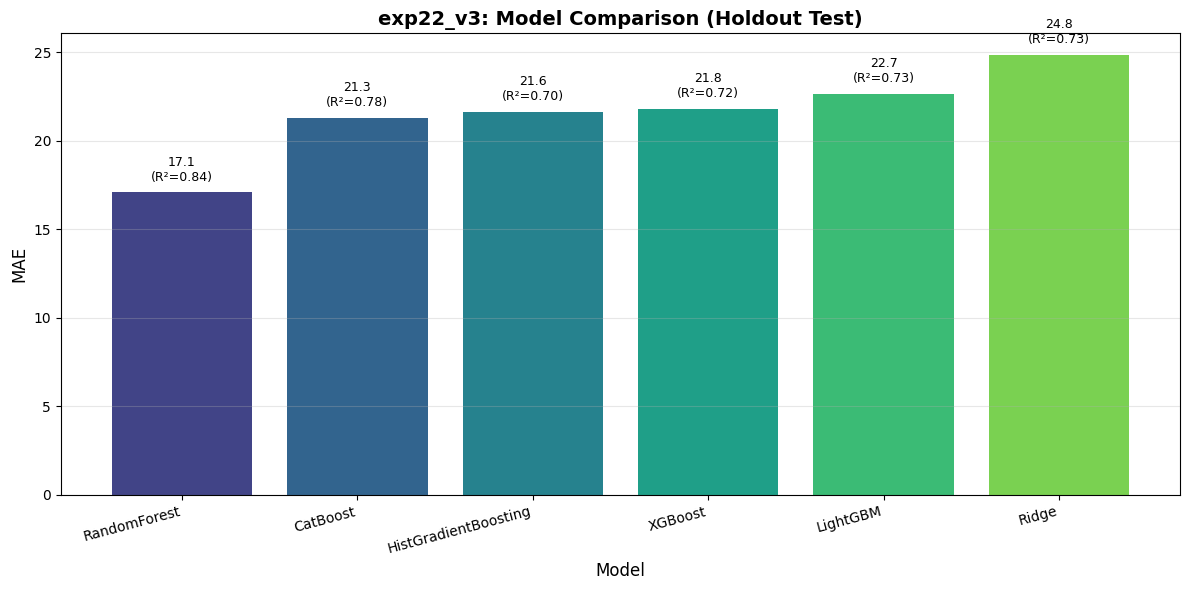


保存しました: ../output/exp22_v3/model_comparison.png


In [17]:
# ==================================================================================
# 可視化
# ==================================================================================

fig, ax = plt.subplots(figsize=(12, 6))

models = final_df['model'].tolist()
maes = final_df['MAE'].tolist()
r2s = final_df['R2'].tolist()

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))
bars = ax.bar(models, maes, color=colors)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('exp22_v3: Model Comparison (Holdout Test)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# MAE値をバーの上に表示
for bar, mae, r2 in zip(bars, maes, r2s):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{mae:.1f}\n(R²={r2:.2f})', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n保存しました: {output_dir}/model_comparison.png")

In [18]:
# ==================================================================================
# 特徴量重要度分析
# ==================================================================================

print("\n" + "=" * 80)
print("特徴量重要度分析（新規モデル）")
print("=" * 80)

# 各モデルの特徴量重要度
importance_data = {}

# XGBoost
importance_data['XGBoost'] = xgboost_opt.feature_importances_

# LightGBM
importance_data['LightGBM'] = lightgbm_opt.feature_importances_

# RandomForest
importance_data['RandomForest'] = rf_opt.feature_importances_

# CatBoost
importance_data['CatBoost'] = catboost_opt.feature_importances_

# DataFrameにまとめる
importance_df = pd.DataFrame({
    'feature': feature_cols_exp22,
    'XGBoost': importance_data['XGBoost'],
    'LightGBM': importance_data['LightGBM'],
    'RandomForest': importance_data['RandomForest'],
    'CatBoost': importance_data['CatBoost']
})

# 各モデルの重要度を表示
for model_name in ['XGBoost', 'LightGBM', 'RandomForest', 'CatBoost']:
    print(f"\n【{model_name}】Top 10")
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=False).head(10)
    print(sorted_df.to_string(index=False))


特徴量重要度分析（新規モデル）

【XGBoost】Top 10
                feature  XGBoost
day_before_holiday_flag 0.370269
                   ma_7 0.083959
               acc_ma_7 0.074885
                  lag_5 0.062791
               ma_std_3 0.056879
         is_rush_period 0.053410
                  lag_1 0.033889
            acc_get_cnt 0.031946
               ma_std_7 0.025295
           week_of_year 0.023165

【LightGBM】Top 10
           feature  LightGBM
      day_of_month       972
          ma_std_7       856
       acc_get_cnt       853
        search_cnt       730
           dow_avg       730
             lag_5       727
days_to_2019_10_01       705
             lag_7       681
           gt_ma_7       676
          acc_ma_7       676

【RandomForest】Top 10
                feature  RandomForest
day_before_holiday_flag      0.309924
                  lag_5      0.160046
                   ma_7      0.143032
               ma_std_3      0.091270
               acc_ma_7      0.067224
               m

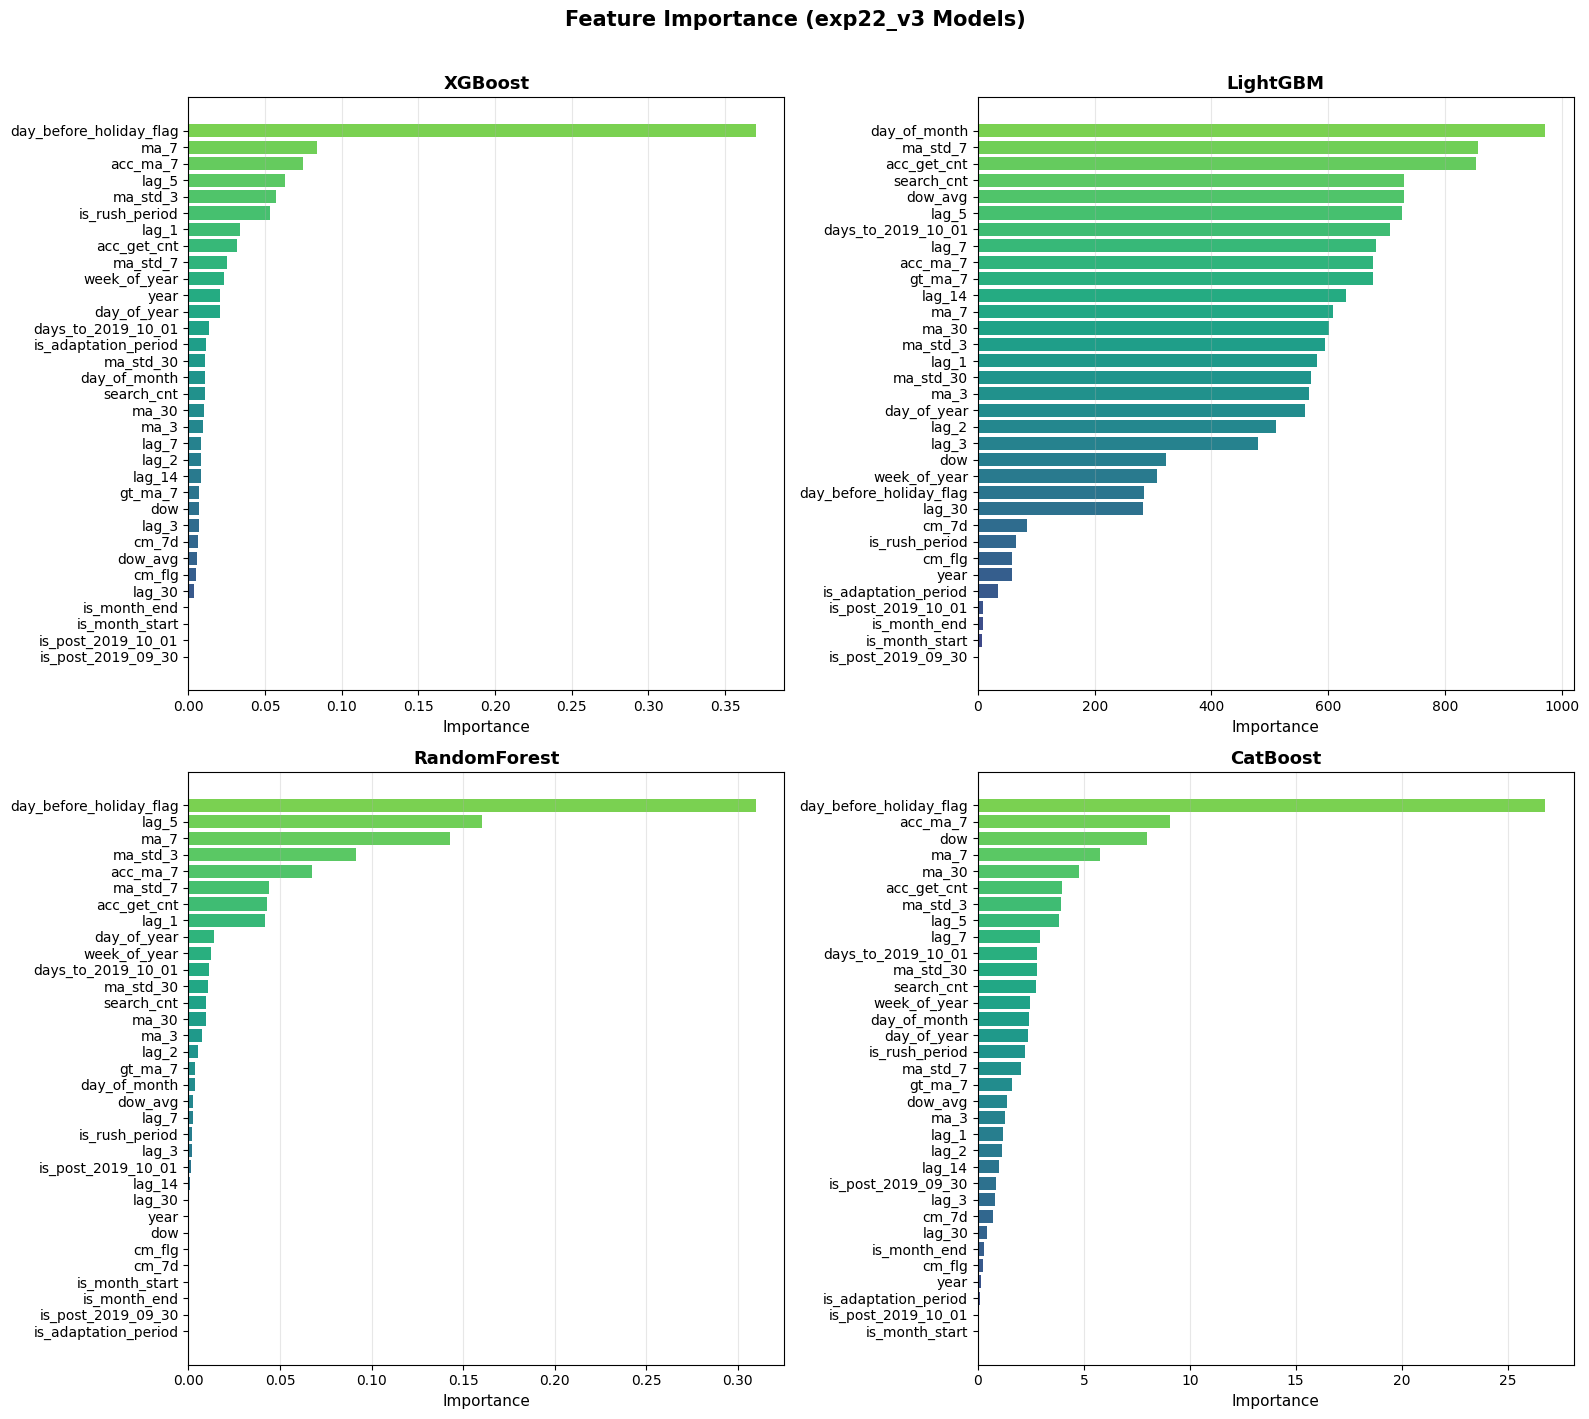


保存しました: ../output/exp22_v3/feature_importance.csv


In [19]:
# ==================================================================================
# 特徴量重要度の可視化
# ==================================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, model_name in enumerate(['XGBoost', 'LightGBM', 'RandomForest', 'CatBoost']):
    ax = axes[idx // 2, idx % 2]
    sorted_df = importance_df[['feature', model_name]].sort_values(model_name, ascending=True)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_df)))
    ax.barh(sorted_df['feature'], sorted_df[model_name], color=colors)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.suptitle('Feature Importance (exp22_v3 Models)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
print(f"\n保存しました: {output_dir}/feature_importance.csv")

In [20]:
# ==================================================================================
# 最終結果の保存
# ==================================================================================

final_df.to_csv(f'{output_dir}/final_results.csv', index=False)

print("\n" + "=" * 80)
print("exp22_v3 最終結果")
print("=" * 80)
print(final_df.to_string(index=False))

print(f"\n保存しました: {output_dir}/final_results.csv")


exp22_v3 最終結果
               model       MAE      RMSE       R2      WAPE
        RandomForest 17.088657 23.583816 0.840396 17.813630
            CatBoost 21.278076 27.867110 0.777157 22.180782
HistGradientBoosting 21.627301 32.517112 0.696584 22.544823
             XGBoost 21.805724 30.990197 0.724410 22.730815
            LightGBM 22.658176 30.941775 0.725270 23.619432
               Ridge 24.840729 30.726674 0.729077 25.894578

保存しました: ../output/exp22_v3/final_results.csv


---

## Summary

**exp22_v3: 追加モデル（XGBoost, LightGBM, RandomForest）のOptuna最適化**

### 使用モデル
- Ridge
- HistGradientBoosting
- CatBoost
- XGBoost（新規）
- LightGBM（新規）
- RandomForest（新規）

### 除外したモデル
- WeightedEnsemble
- ExtraTrees

### 実験内容
1. **Optuna最適化**: 各モデル100トライアル、TimeSeriesCV(n_splits=3)
2. **最終評価**: Holdout Test（exp22と同じ期間）
3. **exp22との比較**

### 出力ファイル
1. `optimized_params.csv` - 最適化パラメータ
2. `final_results.csv` - 最終結果
3. `model_comparison.png` - モデル比較グラフ
4. `feature_importance.csv` - 特徴量重要度
5. `feature_importance.png` - 特徴量重要度グラフ

In [25]:
# 詳細メトリクス出力
def print_metric_details(y_true, y_pred, label=""):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    abs_err = np.abs(y_true - y_pred)
    abs_true = np.abs(y_true)

    n = len(y_true)
    sum_abs_err = abs_err.sum()
    sum_abs_true = abs_true.sum()

    mae = sum_abs_err / n
    wape = (sum_abs_err / sum_abs_true) * 100 if sum_abs_true != 0 else np.nan

    print(f"\n[{label}]")
    print(f"N (母数, MAE): {n}")
    print(f"Σ|y_true - y_pred| (WAPE分子): {sum_abs_err:.6f}")
    print(f"Σ|y_true| (WAPE母数): {sum_abs_true:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"WAPE(%): {wape:.6f}")

# 例: モデル評価後に呼び出し
print_metric_details(y_test, catboost_pred_opt, label="CatBoost Opt")



[CatBoost Opt]
N (母数, MAE): 43
Σ|y_true - y_pred| (WAPE分子): 914.957270
Σ|y_true| (WAPE母数): 4125.000000
MAE: 21.278076
WAPE(%): 22.180782
